# Changing the spectra per epoch


In [1]:
import os
import numpy as np
from astropy.io import fits
from astropy import units as u
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
import os
from concurrent.futures import ThreadPoolExecutor
import time
import gc
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random
from tensorflow.keras.callbacks import EarlyStopping

2024-10-02 17:07:43.947164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 17:07:43.959515: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 17:07:43.963197: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 17:07:43.972668: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 17:07:44.729664: W tensorflow/compiler/tf2

In [21]:
# Create TensorFlow datasets using the loaded data
def create_tf_dataset(spectra_data, labels, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices((spectra_data, labels))
    dataset = dataset.shuffle(buffer_size=len(spectra_data)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def removenan(train_spectra, train_labels, val_spectra, val_labels): 
   # Convert lists to NumPy arrays (remove first 10 spectra to avoid excess NaN values)
    train_spectraa = np.array(train_spectra[10:, :])
    train_labelsa = np.array(train_labels[10:])

    val_spectraa = np.array(val_spectra[10:, :])
    val_labelsa = np.array(val_labels[10:])

    # Remove nan values from the spectra
    mask_train = ~np.isnan(train_spectraa).any(axis=1)
    train_spectranan = train_spectraa[mask_train]
    train_labelsnan = train_labelsa[mask_train]

    mask_val = ~np.isnan(val_spectraa).any(axis=1)
    val_spectranan = val_spectraa[mask_val]
    val_labelsnan = val_labelsa[mask_val]

    del val_spectraa, val_labelsa, mask_val, train_spectraa, train_labelsa, mask_train
    gc.collect()

    # Create TensorFlow datasets
    train_dataset = create_tf_dataset(train_spectranan, train_labelsnan)
    val_dataset = create_tf_dataset(val_spectranan, val_labelsnan)

    del train_spectranan, train_labelsnan
    gc.collect()
    return train_dataset, val_dataset, val_spectranan, val_labelsnan


def generate_file_list_from_directories(base_dirs, limit_per_dir=10000):
    """Generates a list of files and labels from the pre-separated directories."""
    spectra_dirs = {
        "gal_spectra": 0,  # Label 0 for galaxies
        "star_spectra": 1,  # Label 1 for stars
        "agn_spectra": 2,   # Label 2 for AGNs
        "bin_spectra": 3    # Label 3 for binary stars
    }

    file_list = []
    labels = []

    print("Gathering FITS files from pre-separated directories...")
    for dir_name, label in spectra_dirs.items():
        for base_dir in base_dirs:
            dir_path = os.path.join(base_dir, dir_name)
            dir_files = []

            # Collect all files in the directory
            for root, dirs, files in os.walk(dir_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    dir_files.append(file_path)

            # Randomly select files up to the limit
            if len(dir_files) > limit_per_dir:
                selected_files = random.sample(dir_files, limit_per_dir)
            else:
                selected_files = dir_files

            # Append selected files and their labels
            file_list.extend(selected_files)
            labels.extend([label] * len(selected_files))

    print(f"Total spectra files collected: {len(file_list)}")
    return file_list, labels



def generate_datasets_from_preseparated(limit_per_dir=10000):
    """Generates training and validation datasets directly from pre-separated directories."""
    train_base_dir = os.path.join(os.getcwd(), "training_set")
    val_base_dir = os.path.join(os.getcwd(), "validation_set")

    # Load files and labels from the respective directories
    train_files, train_labels = generate_file_list_from_directories([train_base_dir], limit_per_dir)
    val_files, val_labels = generate_file_list_from_directories([val_base_dir], limit_per_dir)

    # Load spectra data in parallel
    train_spectra = load_all_spectra_parallel(train_files)
    val_spectra = load_all_spectra_parallel(val_files)

    # Create TensorFlow datasets
    train_dataset, val_dataset, val_spectranan, val_labelsnan = removenan(train_spectra, train_labels, val_spectra, val_labels)
    
    return train_dataset, val_dataset, val_spectranan, val_labelsnan



def generate_file_list(root_dir=".", limit_per_dir=10000):
    spectra_dirs = {
        "training_set/gal_spectra": 0,  # Label 0 for galaxies
        "training_set/star_spectra": 1,  # Label 1 for stars
        "training_set/agn_spectra": 2,   # Label 2 for AGNs
        "training_set/bin_spectra": 3,   # Label 3 for binary stars
        "validation_set/gal_spectra": 0,  # Label 0 for galaxies (validation)
        "validation_set/star_spectra": 1,  # Label 1 for stars (validation)
        "validation_set/agn_spectra": 2,   # Label 2 for AGNs (validation)
        "validation_set/bin_spectra": 3    # Label 3 for binary stars (validation)
    }

    file_list = []
    labels = []

    print("Gathering FITS files...")
    for dir_name, label in spectra_dirs.items():
        dir_path = os.path.join(root_dir, dir_name)
        dir_files = []

        # Collect all files in the directory
        for root, dirs, files in os.walk(dir_path):
            for file in files:
                file_path = os.path.join(root, file)
                dir_files.append(file_path)
        
        # Randomly select files up to the limit
        if len(dir_files) > limit_per_dir:
            selected_files = random.sample(dir_files, limit_per_dir)
        else:
            selected_files = dir_files
        
        # Append selected files and their labels
        file_list.extend(selected_files)
        labels.extend([label] * len(selected_files))

    print(f"Total spectra files collected: {len(file_list)}")
    return file_list, labels


def create_dataset(file_list, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((file_list, labels))

    def load_and_parse(file_path, label):
        spectra = tf.py_function(load_spectra, [file_path], tf.float32)
        return spectra, label

    dataset = dataset.map(load_and_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(file_list)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


def normalize_spectra(spectra):
    """Normalize spectra by dividing by the mean and applying the natural logarithm."""
    mean_value = np.mean(spectra)
    std_value = np.std(spectra)
    min_value = np.min(spectra)
    if std_value == 0:
        print("Warning: Standard deviation is zero, cannot normalize spectra.")
        return spectra  # Avoid division by zero
    normalized_spectra = ((spectra - min_value + 0.01) / (mean_value - min_value + 0.01)) - 1  # Avoid negative values
    return normalized_spectra



# Example usage
# histories = train_convnet_many_times(convnet_model, epochs_per_run=1, batch_size=32, num_runs=5)

def load_spectra(file_list, target_length=3748):
    """Load spectra from a list of FITS file paths."""
    spectra_data = []
    for file_path in file_list:
        spectra = load_single_spectrum(file_path, target_length)
        if spectra is not None:
            spectra_data.append(spectra)
    return np.array(spectra_data)


def tf_load_single_spectrum(file_path, target_length=3748):
    """TensorFlow wrapper for loading a single spectrum using py_function."""
    spectra = tf.py_function(load_single_spectrum, [file_path, target_length], tf.float32)
    spectra.set_shape([target_length])  # Set the shape explicitly for TensorFlow to optimize
    return spectra


def create_dataset(file_list, labels, batch_size=32, target_length=3748):
    """Create TensorFlow dataset with parallelized loading and optimization."""
    dataset = tf.data.Dataset.from_tensor_slices((file_list, labels))

    def load_and_preprocess(file_path, label):
        spectra = tf_load_single_spectrum(file_path, target_length)
        return spectra, label

    # Apply parallelism and optimizations
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()  # Cache the dataset after loading it once
    dataset = dataset.shuffle(buffer_size=len(file_list))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch to overlap data loading and training

    return dataset
def load_all_spectra_parallel(file_list, target_length=3748, max_workers=512):
    """Load and normalize spectra in parallel using ThreadPoolExecutor."""
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(lambda f: load_single_spectrum(f, target_length), file_list), 
                            total=len(file_list), desc="Loading spectra"))
    # Filter out None results
    spectra_data = [spectrum for spectrum in results if spectrum is not None]
    return np.array(spectra_data)

# Load the validation dataset once and keep it in memory
def load_validation_dataset(limit_per_label=2000):
    val_dataset = generate_datasets_from_preseparated(limit_per_dir=limit_per_label)[1]
    return val_dataset

# Function to train the model with the training dataset and pre-loaded validation dataset
def train_convnet(model, val_dataset, limit_per_label=2000, epochs=1, batch_size=32, patience=5):
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    # Load only the training dataset
    train_dataset= generate_datasets_from_preseparated(limit_per_dir=limit_per_label)[0]
    
    # Fit the model using the pre-loaded validation dataset
    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping])
    
    return history

# Function to train the model multiple times
def train_convnet_many_times(model, val_dataset, epochs_per_run=1, batch_size=32, num_runs=10, limit_per_label=2000):
    histories = []
    for i in range(num_runs):
        print(f"Training run {i+1}/{num_runs}...")
        history = train_convnet(model, val_dataset, limit_per_label=limit_per_label, epochs=epochs_per_run, batch_size=batch_size)
        histories.append(history)
    
    return histories
def load_single_spectrum(file_path, target_length=3748):
    """Load and normalize a single spectrum from a FITS file, truncating or padding to target_length."""
    try:
        with fits.open(file_path) as hdul:
            spectra = hdul[0].data[0]
            spectra = normalize_spectra(spectra)
            
            # Truncate or pad spectra to ensure uniform length
            if len(spectra) > target_length:
                spectra = spectra[:target_length]  # Truncate
            else:
                spectra = np.pad(spectra, (0, max(0, target_length - len(spectra))), mode='constant')  # Pad with zeros
            
            return spectra
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None  # Return None if there's an error

# convnet

In [22]:
def create_convnet(input_shape, num_classes, 
                   num_filters=[128, 128, 128, 128, 128, 128, 128, 128], 
                   kernel_size=(9,),
                   dense_units1=128, 
                   dense_units2=64,
                   dense_units3=32,
                   dense_units4=16,
                   dropout_rate=0.2,
                   padding='same'):
    model = tf.keras.models.Sequential()
    
    # First convolutional layer
    model.add(tf.keras.layers.Conv1D(filters=num_filters[0], kernel_size=kernel_size, 
                                     activation='relu', input_shape=input_shape, padding=padding))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    # Additional convolutional layers
    for filters in num_filters[1:]:
        model.add(tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, 
                                         activation='relu', padding=padding))
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    
    # Flatten the output
    model.add(tf.keras.layers.Flatten())

    # Adding a dense layer
    model.add(tf.keras.layers.Dense(units=dense_units1, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))

    # Adding another dense layer
    if dense_units2:
        model.add(tf.keras.layers.Dense(units=dense_units2, activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))

    # Adding another dense layer
    if dense_units3:
        model.add(tf.keras.layers.Dense(units=dense_units3, activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))

    # Adding another dense layer
    if dense_units4:
        model.add(tf.keras.layers.Dense(units=dense_units4, activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))

    
    # Output layer
    model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

    # Optimizer and loss function
    optimizer_ = tf.keras.optimizers.AdamW(learning_rate=1e-4) 

    # Compile the model
    model.compile(optimizer=optimizer_, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [4]:

num_labels = 4       #len(set(labels))
val_dataset = load_validation_dataset(limit_per_label=2000)


Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 484.27it/s]
I0000 00:00:1727885294.277588   76688 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727885294.300592   76688 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727885294.300660   76688 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727885294.302746   76688 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727885294.302807   76688 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa

In [23]:
len_ = 3748

# Define the model architecture
filters_20=[256, 256, 256, 256, 512, 512, 512, 512, 1024, 1024, 1024]
model_20 = create_convnet(input_shape=(len_-10, 1), num_classes=num_labels, num_filters=filters_20, kernel_size=(9,), dense_units1=512, dense_units2=256, dense_units3=128, dense_units4=64, dropout_rate=0.2)
model_20.summary()

/home/jcwind/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_63 (Conv1D)              │ (None, 3738, 256)      │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_63 (MaxPooling1D) │ (None, 1869, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_64 (Conv1D)              │ (None, 1869, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_64 (MaxPooling1D) │ (None, 934, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 934, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_65 (Conv1D)              │ (None, 934, 256)       │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_65 (MaxPooling1D) │ (None, 467, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 467, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_66 (Conv1D)              │ (None, 467, 256)       │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_66 (MaxPooling1D) │ (None, 233, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 233, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_67 (Conv1D)              │ (None, 233, 512)       │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_67 (MaxPooling1D) │ (None, 116, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 116, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_68 (Conv1D)              │ (None, 116, 512)       │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_68 (MaxPooling1D) │ (None, 58, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 58, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_69 (Conv1D)              │ (None, 58, 512)        │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_69 (MaxPooling1D) │ (None, 29, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 29, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_70 (Conv1D)              │ (None, 29, 512)        │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_70 (MaxPooling1D) │ (None, 14, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 14, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_71 (Conv1D)              │ (None, 14, 1024)       │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_71 (MaxPooling1D) │ (None, 7, 1024)        │             

 Total params: 34,325,956 (130.94 MB)

 Trainable params: 34,325,956 (130.94 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Example usage to get  val_spectranan, val_labelsnan
train_dataset, val_dataset, val_spectranan, val_labelsnan  = generate_datasets_from_preseparated(limit_per_dir=2000)

Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 436.94it/s]


In [24]:
histories = train_convnet_many_times(model_20, val_dataset, epochs_per_run=1, batch_size=32, num_runs=20)

Training run 1/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 460.76it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 33s 185ms/step - accuracy: 0.3381 - loss: 1.3068 - val_accuracy: 0.4786 - val_loss: 1.0604
Training run 2/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 425.87it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.5251 - loss: 1.0367 - val_accuracy: 0.6509 - val_loss: 0.8994
Training run 3/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 458.74it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.6320 - loss: 0.8502 - val_accuracy: 0.6742 - val_loss: 0.7940
Training run 4/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 494.19it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.6626 - loss: 0.7792 - val_accuracy: 0.7264 - val_loss: 0.7159
Training run 5/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 420.68it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.6844 - loss: 0.7120 - val_accuracy: 0.7283 - val_loss: 0.6731
Training run 6/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 454.98it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.7123 - loss: 0.6506 - val_accuracy: 0.7245 - val_loss: 0.6183
Training run 7/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 455.99it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.7211 - loss: 0.6016 - val_accuracy: 0.7447 - val_loss: 0.5805
Training run 8/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 447.50it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.7238 - loss: 0.6040 - val_accuracy: 0.7472 - val_loss: 0.5924
Training run 9/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 432.61it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.7221 - loss: 0.5936 - val_accuracy: 0.7484 - val_loss: 0.5885
Training run 10/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 444.23it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.7353 - loss: 0.5559 - val_accuracy: 0.7428 - val_loss: 0.5312
Training run 11/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 449.15it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.7465 - loss: 0.5259 - val_accuracy: 0.7610 - val_loss: 0.5335
Training run 12/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 444.36it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.7429 - loss: 0.5342 - val_accuracy: 0.7585 - val_loss: 0.5317
Training run 13/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 449.52it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.7311 - loss: 0.5518 - val_accuracy: 0.7465 - val_loss: 0.5327
Training run 14/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 458.11it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.7364 - loss: 0.5535 - val_accuracy: 0.7616 - val_loss: 0.4854
Training run 15/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 451.15it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.7516 - loss: 0.4986 - val_accuracy: 0.7736 - val_loss: 0.4754
Training run 16/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 442.66it/s] 


121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.7659 - loss: 0.5039 - val_accuracy: 0.7742 - val_loss: 0.4821
Training run 17/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 446.67it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.7544 - loss: 0.4928 - val_accuracy: 0.7686 - val_loss: 0.4926
Training run 18/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 452.08it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.7588 - loss: 0.4903 - val_accuracy: 0.7855 - val_loss: 0.4737
Training run 19/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 492.39it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.7739 - loss: 0.4692 - val_accuracy: 0.7836 - val_loss: 0.4692
Training run 20/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 458.29it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.7579 - loss: 0.4897 - val_accuracy: 0.7780 - val_loss: 0.4575


# Conf Matrix

In [9]:
def print_confusion_matrix(convnet_model, val_spectranan, val_labelsnan):   
    # Make predictions on the validation/test dataset
    val_predictions = convnet_model.predict(val_spectranan)

    # Convert the predictions to class labels (assuming one-hot encoding)
    predicted_labels = np.argmax(val_predictions, axis=1)

    # Convert true labels if they are in one-hot encoded format
    true_labels = np.array(val_labelsnan)  # Assuming val_labels is already numeric


    # Generate the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)

    # Optionally, print a classification report for more metrics
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels))

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Galaxy', 'Star', 'AGN', 'Binary Star'], yticklabels=['Galaxy', 'Star', 'AGN', 'Binary Star'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# 4 dense layers

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
Confusion Matrix:
[[376   0   7   7]
 [  1 216   2 181]
 [ 45   2 349   4]
 [  4  94   6 296]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       390
           1       0.69      0.54      0.61       400
           2       0.96      0.87      0.91       400
           3       0.61      0.74      0.67       400

    accuracy                           0.78      1590
   macro avg       0.79      0.78      0.78      1590
weighted avg       0.78      0.78      0.78      1590



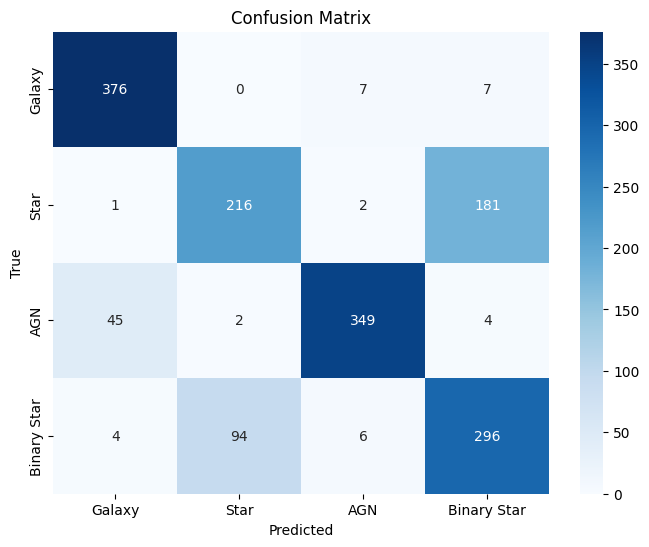

In [25]:
print_confusion_matrix(model_20 , val_spectranan, val_labelsnan)


# 3 dense layers

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Confusion Matrix:
[[374   2   5   9]
 [  2 252   2 144]
 [ 42   7 349   2]
 [  3 109   1 287]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       390
           1       0.68      0.63      0.65       400
           2       0.98      0.87      0.92       400
           3       0.65      0.72      0.68       400

    accuracy                           0.79      1590
   macro avg       0.80      0.79      0.80      1590
weighted avg       0.80      0.79      0.79      1590



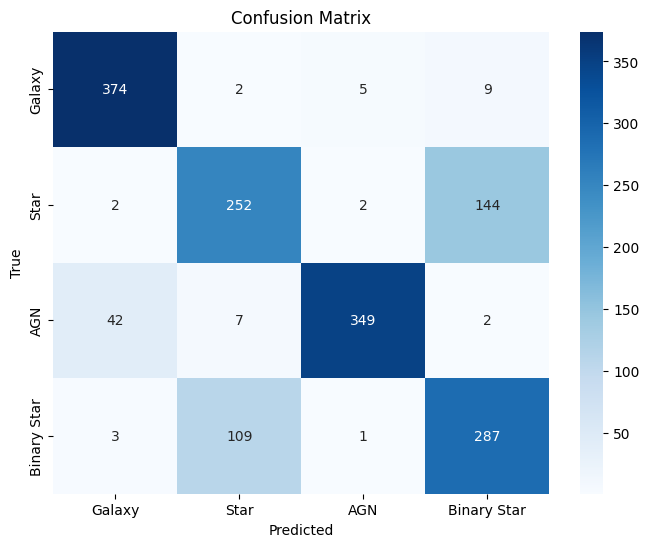

In [18]:
print_confusion_matrix(model_20 , val_spectranan, val_labelsnan)


In [ ]:
# 4 dense layers and 30 size kernel

In [26]:
len_ = 3748
# Define the model architecture
filters_20=[256, 256, 256, 256, 512, 512, 512, 512, 1024, 1024, 1024]
model_20 = create_convnet(input_shape=(len_-10, 1), num_classes=num_labels, num_filters=filters_20, kernel_size=(30,), dense_units1=512, dense_units2=256, dense_units3=128, dense_units4=64, dropout_rate=0.2)
model_20.summary()

/home/jcwind/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_74 (Conv1D)              │ (None, 3738, 256)      │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_74 (MaxPooling1D) │ (None, 1869, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_75 (Conv1D)              │ (None, 1869, 256)      │     1,966,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_75 (MaxPooling1D) │ (None, 934, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 934, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_76 (Conv1D)              │ (None, 934, 256)       │     1,966,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_76 (MaxPooling1D) │ (None, 467, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 467, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_77 (Conv1D)              │ (None, 467, 256)       │     1,966,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_77 (MaxPooling1D) │ (None, 233, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 233, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_78 (Conv1D)              │ (None, 233, 512)       │     3,932,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_78 (MaxPooling1D) │ (None, 116, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 116, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_79 (Conv1D)              │ (None, 116, 512)       │     7,864,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_79 (MaxPooling1D) │ (None, 58, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 58, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_80 (Conv1D)              │ (None, 58, 512)        │     7,864,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_80 (MaxPooling1D) │ (None, 29, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 29, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_81 (Conv1D)              │ (None, 29, 512)        │     7,864,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_81 (MaxPooling1D) │ (None, 14, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 14, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_82 (Conv1D)              │ (None, 14, 1024)       │    15,729,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_82 (MaxPooling1D) │ (None, 7, 1024)        │             

 Total params: 112,777,924 (430.21 MB)

 Trainable params: 112,777,924 (430.21 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
histories = train_convnet_many_times(model_20, val_dataset, epochs_per_run=1, batch_size=32, num_runs=20)

Training run 1/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 451.25it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 108s 544ms/step - accuracy: 0.3560 - loss: 1.2829 - val_accuracy: 0.4836 - val_loss: 1.0718
Training run 2/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 445.37it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 34s 284ms/step - accuracy: 0.4871 - loss: 1.0329 - val_accuracy: 0.6849 - val_loss: 0.8325
Training run 3/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 446.18it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 33s 270ms/step - accuracy: 0.6480 - loss: 0.8340 - val_accuracy: 0.6692 - val_loss: 0.8094
Training run 4/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 466.01it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 33s 271ms/step - accuracy: 0.6662 - loss: 0.7466 - val_accuracy: 0.7000 - val_loss: 0.7854
Training run 5/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 499.22it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 33s 274ms/step - accuracy: 0.6843 - loss: 0.6839 - val_accuracy: 0.7126 - val_loss: 0.6778
Training run 6/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 438.56it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 31s 253ms/step - accuracy: 0.7040 - loss: 0.6396 - val_accuracy: 0.7447 - val_loss: 0.5759
Training run 7/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 500.99it/s] 


121/121 ━━━━━━━━━━━━━━━━━━━━ 33s 266ms/step - accuracy: 0.7259 - loss: 0.5883 - val_accuracy: 0.7528 - val_loss: 0.5592
Training run 8/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 450.91it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 33s 272ms/step - accuracy: 0.7215 - loss: 0.5864 - val_accuracy: 0.7572 - val_loss: 0.5428
Training run 9/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 452.60it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 33s 267ms/step - accuracy: 0.7308 - loss: 0.5596 - val_accuracy: 0.7535 - val_loss: 0.5241
Training run 10/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 453.51it/s] 


121/121 ━━━━━━━━━━━━━━━━━━━━ 33s 272ms/step - accuracy: 0.7531 - loss: 0.5295 - val_accuracy: 0.7491 - val_loss: 0.5217
Training run 11/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 442.43it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 32s 268ms/step - accuracy: 0.7266 - loss: 0.5560 - val_accuracy: 0.7642 - val_loss: 0.5089
Training run 12/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 410.20it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 33s 276ms/step - accuracy: 0.7382 - loss: 0.5175 - val_accuracy: 0.7679 - val_loss: 0.4859
Training run 13/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 440.41it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 33s 274ms/step - accuracy: 0.7410 - loss: 0.5332 - val_accuracy: 0.7686 - val_loss: 0.4935
Training run 14/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 477.64it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 32s 262ms/step - accuracy: 0.7711 - loss: 0.4957 - val_accuracy: 0.7711 - val_loss: 0.4913
Training run 15/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 430.32it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 32s 266ms/step - accuracy: 0.7527 - loss: 0.4924 - val_accuracy: 0.7792 - val_loss: 0.4768
Training run 16/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:04<00:00, 374.29it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 32s 264ms/step - accuracy: 0.7620 - loss: 0.4849 - val_accuracy: 0.7692 - val_loss: 0.4713
Training run 17/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 423.98it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 33s 273ms/step - accuracy: 0.7590 - loss: 0.5112 - val_accuracy: 0.7742 - val_loss: 0.4691
Training run 18/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 428.72it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 34s 282ms/step - accuracy: 0.7375 - loss: 0.5197 - val_accuracy: 0.7799 - val_loss: 0.4646
Training run 19/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 426.84it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 34s 276ms/step - accuracy: 0.7581 - loss: 0.5009 - val_accuracy: 0.7830 - val_loss: 0.4626
Training run 20/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 427.82it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 30s 251ms/step - accuracy: 0.7666 - loss: 0.4618 - val_accuracy: 0.7811 - val_loss: 0.4500


50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step
Confusion Matrix:
[[376   3   6   5]
 [  2 207   7 184]
 [ 39   3 355   3]
 [  5  85   6 304]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       390
           1       0.69      0.52      0.59       400
           2       0.95      0.89      0.92       400
           3       0.61      0.76      0.68       400

    accuracy                           0.78      1590
   macro avg       0.79      0.78      0.78      1590
weighted avg       0.79      0.78      0.78      1590



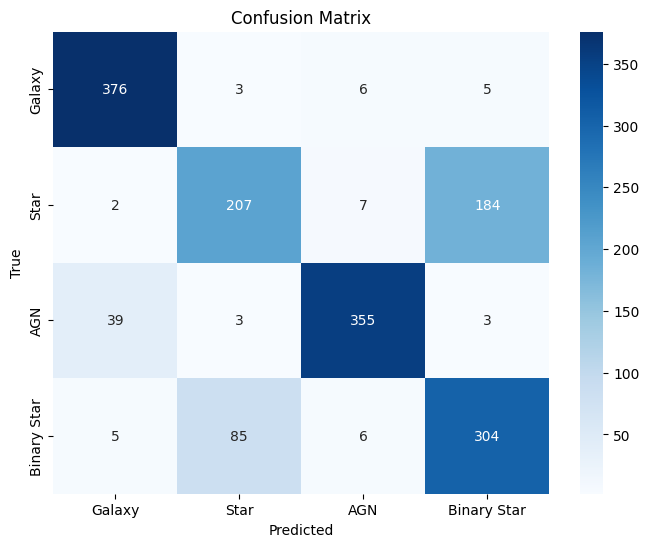

In [28]:
print_confusion_matrix(model_20 , val_spectranan, val_labelsnan)


In [31]:
histories = train_convnet_many_times(model_20, val_dataset, epochs_per_run=1, batch_size=32, num_runs=20)

Training run 1/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:04<00:00, 382.39it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 31s 257ms/step - accuracy: 0.8096 - loss: 0.4168 - val_accuracy: 0.8157 - val_loss: 0.4167
Training run 2/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 429.88it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 32s 258ms/step - accuracy: 0.8145 - loss: 0.3905 - val_accuracy: 0.7836 - val_loss: 0.4346
Training run 3/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 429.94it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 31s 251ms/step - accuracy: 0.8064 - loss: 0.4085 - val_accuracy: 0.8119 - val_loss: 0.4133
Training run 4/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 422.79it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 30s 250ms/step - accuracy: 0.8152 - loss: 0.3907 - val_accuracy: 0.8107 - val_loss: 0.4345
Training run 5/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 429.60it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 31s 253ms/step - accuracy: 0.8118 - loss: 0.3995 - val_accuracy: 0.8270 - val_loss: 0.3894
Training run 6/20...
Gathering FITS files from pre-separated directories...
Total spectra files collected: 7699
Gathering FITS files from pre-separated directories...
Total spectra files collected: 1600


Loading spectra: 100%|██████████| 1600/1600 [00:04<00:00, 326.92it/s]


121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8189 - loss: 0.3777

50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step
Confusion Matrix:
[[365   1  19   5]
 [  1 237   3 159]
 [ 24   2 369   5]
 [  1  71   3 325]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       390
           1       0.76      0.59      0.67       400
           2       0.94      0.92      0.93       400
           3       0.66      0.81      0.73       400

    accuracy                           0.82      1590
   macro avg       0.82      0.82      0.81      1590
weighted avg       0.82      0.82      0.81      1590



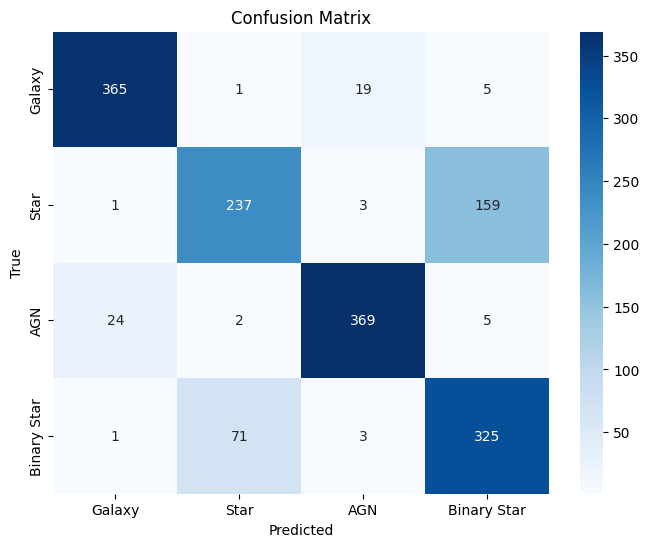

In [30]:
print_confusion_matrix(model_20 , val_spectranan, val_labelsnan)


In [ ]:
len_ = 3748
# Define the model architecture
filters_20=[256, 256, 256, 256, 512, 512, 512, 512, 1024, 1024, 1024]
model_20 = create_convnet(input_shape=(len_-10, 1), num_classes=num_labels, num_filters=filters_20, kernel_size=(30,), dense_units1=512, dense_units2=256, dense_units3=128, dense_units4=64, dropout_rate=0.2)
model_20.summary()